In [1]:
import sys
import os

try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    print('Not running in Google Colab. Using local paths.')

# Project paths
if IN_COLAB:
    project_path = '/content/drive/MyDrive/Deep_learning_papers/Neural_probabilistic_laguage_model'
    mlflow_tracking_path = '/content/drive/MyDrive/Deep_learning_papers/Neural_probabilistic_laguage_model/mlruns'
else:
    project_path = '.'
    mlflow_tracking_path = './mlruns'

# Create mlruns directory if it doesn't exist
os.makedirs(mlflow_tracking_path, exist_ok=True)

if project_path not in sys.path:
    sys.path.insert(0, project_path)

from utils.data_preparator import *
from utils.functions import *

from abstractions.classes import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Using device: cuda
GPU: Tesla T4


In [2]:
#Mlflow setup

try:
    import mlflow
except ImportError:
    !pip install mlflow -q
    import mlflow

import mlflow.pytorch

# Set the tracking URI to Google Drive path for persistence
mlflow.set_tracking_uri(f'file://{mlflow_tracking_path}')

# Create or get experiment
experiment_name = 'bengio_language_model'
mlflow.set_experiment(experiment_name)

print(f'MLflow tracking URI: {mlflow.get_tracking_uri()}')
print(f'MLflow experiment: {experiment_name}')

MLflow tracking URI: file:///content/drive/MyDrive/Deep_learning_papers/Neural_probabilistic_laguage_model/mlruns
MLflow experiment: bengio_language_model


/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


In [3]:
import nltk
nltk.download('brown')
from nltk.corpus import brown
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import random
import math

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [4]:
# Wyczyść cache i zresetuj
torch.cuda.empty_cache()
if torch.cuda.is_available():
    torch.cuda.synchronize()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
if device == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: Tesla T4


In [5]:
experiments = [
    # Small configuration (from Bengio paper)
    {
        'embedding_dim': 30,
        'hidden_dim': 50,
        'learning_rate': 0.1,
        'batch_size': 64,
        'context_window': 3,
        'max_steps': 10000,
        'eval_interval': 1000,
    },
    # Medium configuration (from Bengio paper)
    {
        'embedding_dim': 60,
        'hidden_dim': 100,
        'learning_rate': 0.1,
        'batch_size': 64,
        'context_window': 3,
        'max_steps': 10000,
        'eval_interval': 1000,
    }
]

print(f'Configured {len(experiments)} experiments:')
for i, exp in enumerate(experiments, 1):
    print(f'  {i}. n_emb={exp["embedding_dim"]}, n_hidden={exp["hidden_dim"]}')

Configured 2 experiments:
  1. n_emb=30, n_hidden=50
  2. n_emb=60, n_hidden=100


In [6]:
results = []

for i, params in enumerate(experiments, 1):
    print(f'\n{"#"*60}')
    print(f'Running Experiment {i}/{len(experiments)}')
    print(f'{"#"*60}')

    result = train_experiment(params)
    result['config'] = params
    results.append(result)

    # Clear CUDA cache between experiments
    if device == 'cuda':
        torch.cuda.empty_cache()

print(f'\n{"="*60}')
print('All experiments completed!')
print(f'{"="*60}')


############################################################
Running Experiment 1/2
############################################################
 There are: 1161192 tokens in dataset
torch.Size([1161192, 3]) torch.Size([1161192])

Starting experiment: n_emb=30, n_hidden=50
Model parameters: 1,356,521
Vocab size: 16691

Step      0/10000: train_loss=9.9039, val_loss=9.9044, train_ppl=20007.26, val_ppl=20017.94
Step   1000/10000: train_loss=6.9919, val_loss=6.9866, train_ppl=1087.83, val_ppl=1082.03
Step   2000/10000: train_loss=6.7323, val_loss=6.7304, train_ppl=839.11, val_ppl=837.52
Step   3000/10000: train_loss=6.6088, val_loss=6.6067, train_ppl=741.58, val_ppl=740.02
Step   4000/10000: train_loss=6.5283, val_loss=6.5286, train_ppl=684.21, val_ppl=684.42
Step   5000/10000: train_loss=6.4687, val_loss=6.4691, train_ppl=644.62, val_ppl=644.88
Step   6000/10000: train_loss=6.4233, val_loss=6.4237, train_ppl=616.05, val_ppl=616.30
Step   7000/10000: train_loss=6.3843, val_loss=6.3862, t

In [7]:
print('\nExperiment Summary:')
print('-' * 80)
print(f'{"Config":^25} | {"Params":>10} | {"Train PPL":>10} | {"Val PPL":>10} | {"Test PPL":>10}')
print('-' * 80)

for r in results:
    config = r['config']
    config_str = f"n_emb={config['embedding_dim']}, n_h={config['hidden_dim']}"
    print(f'{config_str:^25} | {r["n_params"]:>10,} | {r["train_perplexity"]:>10.2f} | {r["val_perplexity"]:>10.2f} | {r["test_perplexity"]:>10.2f}')

print('-' * 80)

best_result = min(results, key=lambda x: x['val_perplexity'])
best_config = best_result['config']
print(f'\nBest model by validation perplexity:')
print(f'  Config: n_emb={best_config["embedding_dim"]}, n_hidden={best_config["hidden_dim"]}')
print(f'  Val Perplexity: {best_result["val_perplexity"]:.2f}')
print(f'  Run ID: {best_result["run_id"]}')


Experiment Summary:
--------------------------------------------------------------------------------
         Config           |     Params |  Train PPL |    Val PPL |   Test PPL
--------------------------------------------------------------------------------
    n_emb=30, n_h=50      |  1,356,521 |     548.48 |     551.13 |     549.43
    n_emb=60, n_h=100     |  2,705,351 |     461.24 |     472.56 |     472.43
--------------------------------------------------------------------------------

Best model by validation perplexity:
  Config: n_emb=60, n_hidden=100
  Val Perplexity: 472.56
  Run ID: 961e0558f22c46529b9e4f8ac114491a


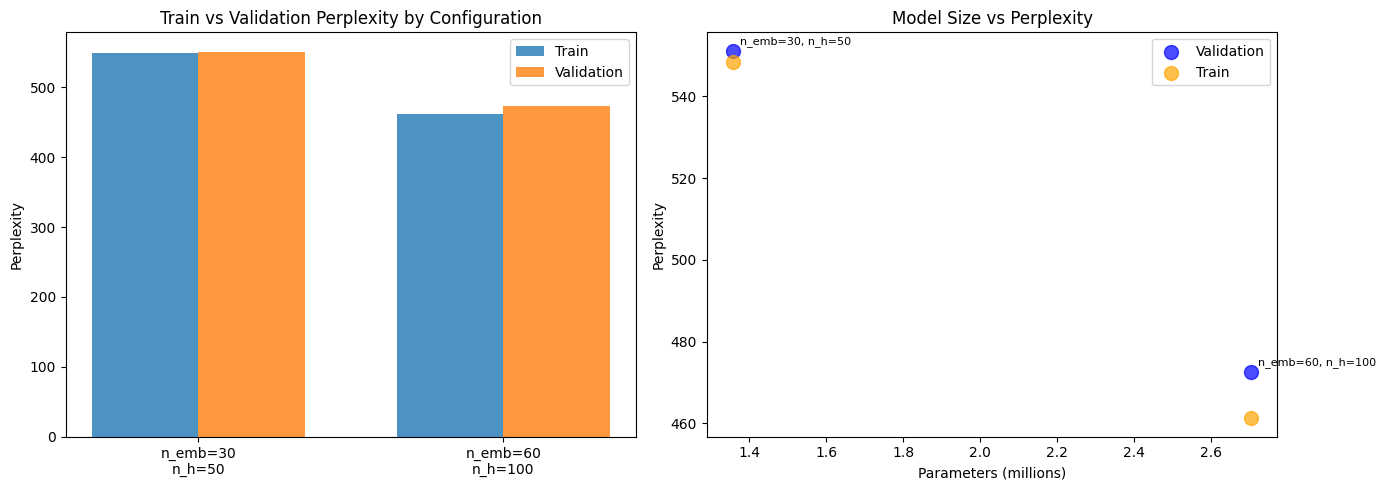

In [8]:
# Cell 12: Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get data for plotting
configs = [f"n_emb={r['config']['embedding_dim']}\nn_h={r['config']['hidden_dim']}" for r in results]
val_ppls = [r['val_perplexity'] for r in results]
train_ppls = [r['train_perplexity'] for r in results]
n_params = [r['n_params'] / 1e6 for r in results]  # in millions

# Plot 1: Perplexity comparison
x = range(len(configs))
width = 0.35
axes[0].bar([i - width/2 for i in x], train_ppls, width, label='Train', alpha=0.8)
axes[0].bar([i + width/2 for i in x], val_ppls, width, label='Validation', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(configs)
axes[0].set_ylabel('Perplexity')
axes[0].set_title('Train vs Validation Perplexity by Configuration')
axes[0].legend()

# Plot 2: Parameters vs Perplexity
axes[1].scatter(n_params, val_ppls, s=100, c='blue', alpha=0.7, label='Validation')
axes[1].scatter(n_params, train_ppls, s=100, c='orange', alpha=0.7, label='Train')
for i, txt in enumerate(configs):
    axes[1].annotate(txt.replace('\n', ', '), (n_params[i], val_ppls[i]),
                     textcoords="offset points", xytext=(5, 5), fontsize=8)
axes[1].set_xlabel('Parameters (millions)')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Model Size vs Perplexity')
axes[1].legend()

plt.tight_layout()
plt.show()

In [9]:
# Cell 13: Text generation with best model
def generate_sentence(model, itos, context_size=3, max_len=20, device=None):
    """Generate a sentence using the trained model.

    Args:
        device: Device to use. If None, uses the global device variable.
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    context = [0] * context_size  # Start with padding/block
    out = []

    for _ in range(max_len):
        x = torch.tensor([context], device=device)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()

        if ix == 0:  # End of sentence / Block
            break

        context = context[1:] + [ix]
        out.append(ix)

    return ' '.join(itos[i] for i in out)

# Generate sentences with best model
print('Generated sentences from best model:')
print('-' * 50)
for i in range(5):
    sentence = generate_sentence(
        best_result['model'],
        best_result['itos'],
        context_size=best_config['context_window'],
        device=device
    )
    print(f'{i+1}. {sentence}')

Generated sentences from best model:
--------------------------------------------------
1. , and the personal chinese that he would press affection wilhelm already about this is . that things to peru
2. as a neighbor school of his skirt , at to <unk> what business twice <unk> the small money shy kinds
3. in picket anne beauty , <unk> , skins foot always specifies scratching and school and <unk> , out molly that
4. or ' blue is hard-surface to work gasoline . chlorine with a new badness . since systems did do conditions
5. of <unk> certain chat not <unk> '' , or back in the ignore familiar the world . this experience <unk>


In [10]:
# Cell 14: View MLflow experiment info
print(f'\nMLflow UI: Run `mlflow ui` in terminal at {mlflow_tracking_path}')
print(f'Or in Colab, access via ngrok tunneling.')
print(f'\nExperiment runs saved to: {mlflow_tracking_path}')

# List runs in the experiment
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment:
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    print(f'\nNumber of runs in experiment: {len(runs)}')
    if len(runs) > 0:
        print('\nRecent runs:')
        print(runs[['run_id', 'params.embedding_dim', 'params.hidden_dim', 'metrics.final_val_perplexity']].to_string())


MLflow UI: Run `mlflow ui` in terminal at /content/drive/MyDrive/Deep_learning_papers/Neural_probabilistic_laguage_model/mlruns
Or in Colab, access via ngrok tunneling.

Experiment runs saved to: /content/drive/MyDrive/Deep_learning_papers/Neural_probabilistic_laguage_model/mlruns

Number of runs in experiment: 5

Recent runs:
                             run_id params.embedding_dim params.hidden_dim  metrics.final_val_perplexity
0  961e0558f22c46529b9e4f8ac114491a                   60               100                    472.559720
1  8a95a431fc8043219c4c12d4c19237fd                   30                50                    551.125049
2  1b6169e696fa45dfa2308aab7e38cc9e                   30                50                           NaN
3  ac2b3f4a03d641a0ab57daea5a48a9f5                   30                50                           NaN
4  cc7b5a5cb32f42bcad93b6da7b957f05                   30                50                           NaN
